In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import os

In [3]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

In [4]:
from uncertainties import ufloat, unumpy

In [5]:
DATA_NU = '/data/icecube/data/NuTeV/nutev_data/data/nutevpack/NuVec.dat'
DATA_NUBAR= '/data/icecube/data/NuTeV/nutev_data/data/nutevpack/NubarVec.dat'
Y_BINNING = np.array([0, 0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.97, 1.0])
X_BINNING = np.array([0.0001, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
E_BINNING = np.array([30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 230, 260, 290, 320, 360])
Y_CENTERS = np.array([0.0005, 0.026, 0.075, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.935, 0.985])
X_CENTERS = np.array([0.015, 0.045, 0.08, 0.125, 0.175, 0.225, 0.275, 0.35, 0.45, 0.55, 0.65, 0.75])
E_CENTERS = np.array([35, 45, 55, 65, 75, 85, 95, 110, 130, 150, 170, 190, 215, 245, 275, 305, 340])
print(map(len, (Y_BINNING, X_BINNING, E_BINNING)))

[14, 13, 18]


In [6]:
with open(DATA_NU, 'r') as f:
    table_nu = np.genfromtxt(f, usecols=range(9), skip_header=1)
with open(DATA_NUBAR, 'r') as f:
    table_nubar = np.genfromtxt(f, usecols=range(9), skip_header=1)

In [7]:
def decode_index(index):
    ybin = index % 100 - 1
    xbin = ((index % 10000) - ybin) / 100 - 1 - 1
    ebin = ((index % 1000000) - xbin*100 -ybin)/10000 - 1 - 1

    return [map(int, (ebin, xbin, ybin))]

nu_decoded_index, nubar_decoded_index = [], []
for index in table_nu[:,0]:
    nu_decoded_index.append(decode_index(index))
for index in table_nubar[:,0]:
    nubar_decoded_index.append(decode_index(index))
nu_decoded_index = np.vstack(nu_decoded_index)
nubar_decoded_index = np.vstack(nubar_decoded_index)
print(nu_decoded_index)

[[ 0  1  5]
 [ 0  1  6]
 [ 0  1  7]
 ..., 
 [16 11  2]
 [16 11  3]
 [16 11  4]]


In [8]:
nu_sys = table_nu[:,3:].T
nubar_sys = table_nubar[:,3:].T
print(nu_sys.shape)
nu_sys_err_2 = nu_sys[0]**2 + nu_sys[1]**2 + nu_sys[2]**2 + nu_sys[3]**2 + nu_sys[4]**2 + nu_sys[5]**2
nubar_sys_err_2 = nubar_sys[0]**2 + nubar_sys[1]**2 + nubar_sys[2]**2 + nubar_sys[3]**2 + nubar_sys[4]**2 + nubar_sys[5]**2
nu_xsec_array = unumpy.uarray(table_nu[:,1], np.sqrt(table_nu[:,2]**2 + nu_sys_err_2))
nubar_xsec_array = unumpy.uarray(table_nubar[:,1], np.sqrt(table_nubar[:,2]**2 + nubar_sys_err_2))

(6, 1423)


In [9]:
nu_data_matrix = np.zeros(map(len, (E_CENTERS, X_CENTERS, Y_CENTERS)))
nubar_data_matrix = np.zeros(map(len, (E_CENTERS, X_CENTERS, Y_CENTERS)))
nu_data_matrix, nubar_data_matrix = unumpy.uarray(nu_data_matrix, nu_data_matrix), \
                                    unumpy.uarray(nubar_data_matrix, nubar_data_matrix)
print(nu_data_matrix.shape)
for idx, entry in enumerate(nu_decoded_index):
    nu_data_matrix[tuple(entry)] = nu_xsec_array[idx]
for idx, entry in enumerate(nubar_decoded_index):
    nubar_data_matrix[tuple(entry)] = nubar_xsec_array[idx]
nu_data_matrix, nubar_data_matrix = ma.masked_equal(nu_data_matrix, 0), ma.masked_equal(nubar_data_matrix, 0)

(17, 12, 13)


In [10]:
def format_axis(ax, x_label=r'', title=r'', lhs=False, ylim=None):
    ax.set_title(title)

    ax.set_xlim(np.min(Y_BINNING), np.max(Y_BINNING))
    #for xmaj in ax.xaxis.get_majorticklocs():
    for xmaj in Y_BINNING:
        ax.axvline(x=xmaj, ls=':', color='gray', alpha=0.4, linewidth=1)
    if x_label == r'':
        ax.get_xaxis().set_ticks([])
    else:
        ax.set_xlabel(x_label, fontsize=14)

    ax.tick_params(axis='y', labelsize=10)
    if not ylim is None:
        ax.set_ylim(ylim)
    #ax.set_ylim(1, 7000)
    #ax.set_yscale('log')
    for ymaj in ax.yaxis.get_majorticklocs():
        ax.axhline(y=ymaj, ls=':', color='gray', alpha=0.4, linewidth=1)
    if not lhs:
        ax.get_yaxis().set_ticks([])
        xticks = ax.xaxis.get_major_ticks()
        try:
            xticks[0].set_visible(False)
        except:
            pass
    else:
        yticks = ax.yaxis.get_major_ticks()
        for yt in yticks:
            yt.label.set_fontsize(9)
        yticks[0].set_visible(False)

def plot_histo(ax, array, colour):
    ax.errorbar(
        Y_CENTERS, unumpy.nominal_values(array), xerr=0, yerr=unumpy.std_devs(array),
        capsize=1.5, alpha=1, color=colour, linestyle='-', markersize=3, linewidth=0.4
    )

E: 9, 150


/data/mandalia/programs/anaconda2/envs/pisa/lib/python2.7/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


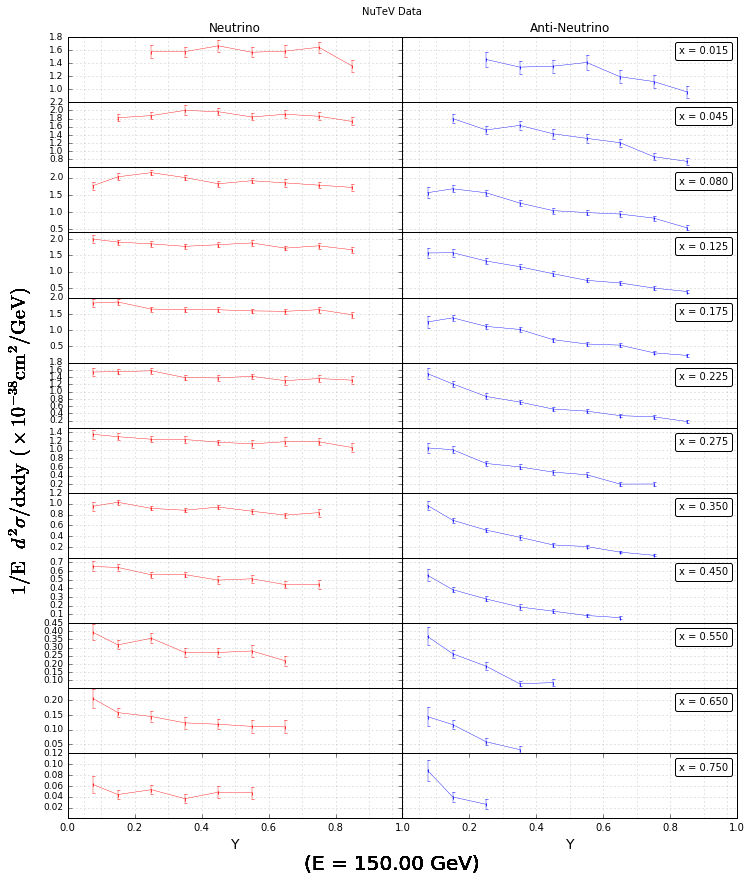

In [11]:
#E_PLOT = None
#E_PLOT = [65, 150, 245]
E_PLOT = [150]
for e_idx, e_bin in enumerate(E_BINNING[:-1]):
    e_cont = True
    if E_PLOT is None:
        e_cont = False
    else:
        for x in E_PLOT:
            if x >= e_bin and x < E_BINNING[e_idx + 1]:
                e_cont = False
    if e_cont:
        continue
    print(r'E: {0}, {1}'.format(e_idx, E_CENTERS[e_idx]))
    fig = plt.figure(figsize=[12, 14])
    fig.suptitle(r'NuTeV Data', y=0.93)
    gs = gridspec.GridSpec(len(X_CENTERS), 1)
    gs.update(hspace=0., wspace=0.)
    
    for x_idx, x_bin in enumerate(X_BINNING[:-1]):
        gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[x_idx],
                                               wspace=0, hspace=0, width_ratios=[1,1])
        ax0 = fig.add_subplot(gs0[0])
        plot_histo(ax0, nu_data_matrix[e_idx][x_idx], colour='red')
        
        ax1 = fig.add_subplot(gs0[1])
        plot_histo(ax1, nubar_data_matrix[e_idx][x_idx], colour='blue')
        
        ylim = (np.min([ax0.get_ylim()[0], ax1.get_ylim()[0]]),
                np.max([ax0.get_ylim()[1], ax1.get_ylim()[1]]))
        #ylim = (0, 2)
        ax0.set_ylim(ylim)
        ax1.set_ylim(ylim)
        if x_idx == 0:
            format_axis(ax0, title=r'Neutrino', lhs=True)
            format_axis(ax1, title=r'Anti-Neutrino')
        elif x_idx == len(X_CENTERS)-1:
            format_axis(ax0, x_label=r'Y', lhs=True)
            format_axis(ax1, x_label=r'Y')
        else:
            format_axis(ax0, lhs=True)
            format_axis(ax1)
        
        at = AnchoredText(r'x = {0:.3f}'.format(X_CENTERS[x_idx]),
                          prop=dict(size=10), frameon=True, loc=1)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax1.add_artist(at)
        
        fig.text(0.055, 0.5, r'$\rm{1/E}$  $d^2\sigma/\rm{dx dy}$ $(\times 10^{-38}\rm{cm}^2/\rm{GeV})$',
                 rotation='vertical', va='center', size=20)
        fig.text(0.5, 0.075, r'(E = {0:.2f} GeV)'.format(E_CENTERS[e_idx]), ha='center', size=20)
        
    #fig.savefig('./images/NuTeV/data/{0:06.2f}_.png'.format(E_CENTERS[e_idx]), bbox_inches='tight')

In [12]:
def get_bin_sizes(bin_edges):
    return np.abs(np.diff(bin_edges))
x_bin_sizes = get_bin_sizes(X_BINNING).astype(float)
y_bin_sizes = get_bin_sizes(Y_BINNING).astype(float)
print(x_bin_sizes)
print(y_bin_sizes)
WA_NU = 0.677
WA_NUBAR = 0.334
print(WA_NU, WA_NUBAR)

[ 0.0299  0.03    0.04    0.05    0.05    0.05    0.05    0.1     0.1     0.1
  0.1     0.1   ]
[ 0.001  0.049  0.05   0.1    0.1    0.1    0.1    0.1    0.1    0.1    0.1
  0.07   0.03 ]
0.677 0.334


In [13]:
for e_idx, e_bin in enumerate(E_CENTERS):
    integral= 0
    for x_idx, x_bin in enumerate(X_CENTERS):
        integral += np.sum(nu_data_matrix[e_idx][x_idx].data * y_bin_sizes) * x_bin_sizes[x_idx]
    print(integral)

0.1609+/-0.0021
0.2760+/-0.0023
0.3060+/-0.0024
0.4178+/-0.0025
0.4248+/-0.0024
0.4478+/-0.0026
0.4732+/-0.0032
0.4878+/-0.0028
0.5132+/-0.0035
0.5376+/-0.0035
0.5194+/-0.0030
0.5561+/-0.0032
0.5640+/-0.0030
0.5582+/-0.0035
0.636+/-0.006
0.570+/-0.009
0.573+/-0.013


In [14]:
for e_idx, e_bin in enumerate(E_CENTERS):
    integral= 0
    for x_idx, x_bin in enumerate(X_CENTERS):
        integral += np.sum(nubar_data_matrix[e_idx][x_idx].data * y_bin_sizes) * x_bin_sizes[x_idx]
    print(integral)

0.0779+/-0.0016
0.1345+/-0.0016
0.1463+/-0.0014
0.2172+/-0.0019
0.2159+/-0.0018
0.2233+/-0.0019
0.2346+/-0.0021
0.2407+/-0.0020
0.2623+/-0.0028
0.2689+/-0.0029
0.2777+/-0.0028
0.2685+/-0.0028
0.2881+/-0.0028
0.2767+/-0.0035
0.288+/-0.006
0.252+/-0.008
0.152+/-0.012


In [58]:
import h5py
h5file = h5py.File('/data/icecube/data/NuTeV/nutev_data/data/nutevpack/NuMatr.hdf5', 'w')
h5file.create_dataset('NuMatr', data=inv_cov_table_nu)
h5file.close()
h5file = h5py.File('/data/icecube/data/NuTeV/nutev_data/data/nutevpack/NubarMatr.hdf5', 'w')
h5file.create_dataset('NubarMatr', data=inv_cov_table_nubar)
h5file.close()

In [32]:
DATA_NU_COV = '/data/icecube/data/NuTeV/nutev_data/data/nutevpack/NuMatr.hdf5'
DATA_NUBAR_COV = '/data/icecube/data/NuTeV/nutev_data/data/nutevpack/NubarMatr.hdf5'

In [33]:
import h5py
h5file_nu = h5py.File(DATA_NU_COV, 'r')
h5file_nubar = h5py.File(DATA_NUBAR_COV, 'r')
inv_cov_table_nu = np.array(h5file_nu['NuMatr'][:])
inv_cov_table_nubar = np.array(h5file_nubar['NubarMatr'][:])
h5file_nu.close()
h5file_nubar.close()

In [55]:
with open('/data/icecube/data/NuTeV/nutev_data/data/nutevpack/errmatrix_nu', 'r') as f:
    inv_cov_table_nu = np.genfromtxt(f, skip_header=11)

In [56]:
print(inv_cov_table_nu.shape)
inv_cov_matrix_nu = inv_cov_table_nu.reshape(map(len, (E_CENTERS, X_CENTERS, Y_CENTERS)) * 2)

(7033104,)


In [57]:
print(inv_cov_matrix_nu.shape)
inv_cov_matrix_nu[9][4][4][9][4][4]

(17, 12, 13, 17, 12, 13)


278.22271699999999

In [13]:
with open('/data/icecube/data/NuTeV/nutev_data/data/nutevpack/NubarMatr.dat', 'r') as f:
    cov_table_nubar = np.loadtxt(f)

In [21]:
shape = np.sqrt(len(cov_table_nubar))
assert(shape.is_integer())
shape = int(shape)
print(cov_table_nubar.shape)
cov_matr_data_nubar = cov_table_nubar.reshape(shape, shape)

(1428025,)


In [36]:
from itertools import product